In [1]:
import numpy as np
from numpy.fft import *
import scipy
from scipy import ndimage
import matplotlib
from matplotlib import pyplot as plt
import pickle
import glob
import tiff_file

import radiav

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
%matplotlib notebook  
#for having plots appear inline

In [3]:
#function for finding autocorrelation
def return_autocorrelation_of_frame(image_frame):
    
    #normalize the image
    data = image_frame - image_frame.mean()
    data = data / data.std()
    
    #compute autocorrelation using fourier transforms
    result = np.real(fftshift(ifft2(fft2(data)*np.conj(fft2(data)))))
    result = result / (data.shape[0]*data.shape[1])
    
    return result

In [4]:
#data_directory = "Z:\\JackBrady_F19\\Data\\2020-01-31_40X_Cone_10XL_pNIPAM\\"
#data_directory = "Y:\\JackBrady_F19\\Data\\2020-01-23_40X_10XL_pNIPAM\\"
data_directory = "Z:\\JackBrady_F19\\Data\\2020-01-30_40X_Cone_10XL_pNIPAM\\"

In [136]:
condition = "*_30Hz_29C_2" #changed "*_5Hz_22C*" bc it wouldn't go into all 3 directories
subdirectories = glob.glob(data_directory + condition)
if len(subdirectories)>0:
    print("Found %i subdirectories matching string." % len(subdirectories))
    filenames = glob.glob(subdirectories[0]+'\\*.tif')
    if len(filenames)==0:
        print("NO FILE FOUND!")
    else:
        print("Found %i files matching string." % len(filenames))
        file_to_use = 0 #Change this if there are multiple files with the same name
        filename = filenames[file_to_use]
        print("Using file: ", filename)
else:
    print("NO SUBDIRECTORY FOUND!")
    

Found 1 subdirectories matching string.
Found 1 files matching string.
('Using file: ', 'Z:\\JackBrady_F19\\Data\\2020-01-30_40X_Cone_10XL_pNIPAM\\04_2FPS_900s_30Hz_29C_2\\04_2FPS_900s_30Hz_29C_2_MMStack_Default.ome.tif')


In [137]:
#read in image data
image_data = tiff_file.imread(filename)

In [138]:
#find the background by taking the median of all images
median_of_images = np.median(image_data[:500], axis=0)
print("Dimensions of median of all images: ", median_of_images.shape)

('Dimensions of median of all images: ', (492L, 656L))


<IPython.core.display.Javascript object>


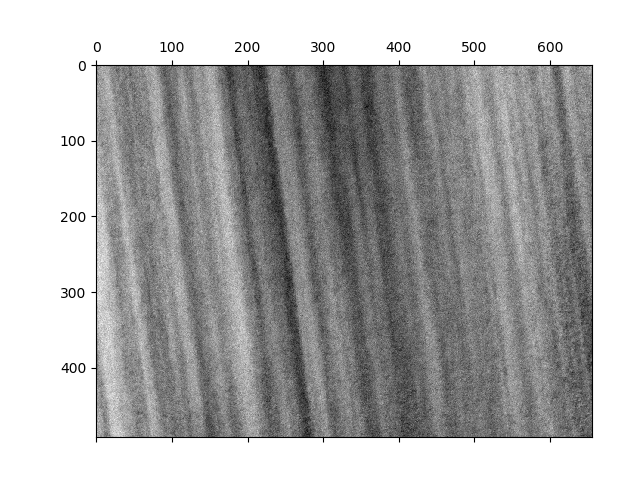

In [139]:
#display an example image with the background subtracted off
plt.matshow(image_data[1400] - median_of_images, cmap=matplotlib.pyplot.cm.gray)

<IPython.core.display.Javascript object>


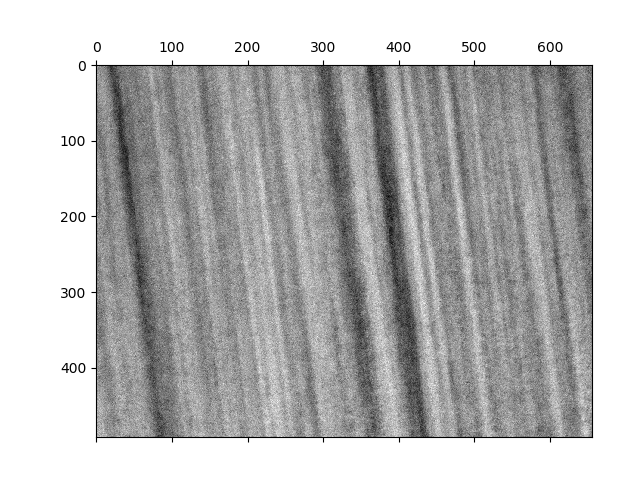

In [140]:
frame_num = 1200
bg_subtracted = image_data[frame_num] - median_of_images
gaus_filter_size = 100
smoothed_image = ndimage.gaussian_filter(bg_subtracted, gaus_filter_size)
plt.matshow(bg_subtracted - smoothed_image, cmap=matplotlib.pyplot.cm.gray)

In [141]:
image_corr = return_autocorrelation_of_frame(bg_subtracted - smoothed_image)

<IPython.core.display.Javascript object>


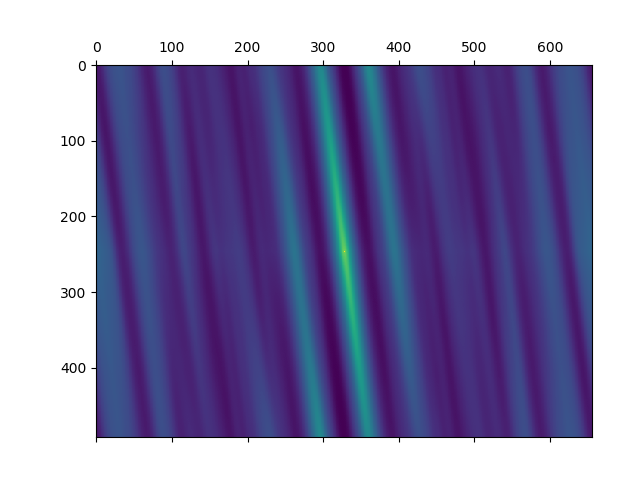

In [142]:
plt.matshow(image_corr)
plt.savefig(filename[:-8]+"image_corr_for_frame_%i.png" % frame_num)

<IPython.core.display.Javascript object>


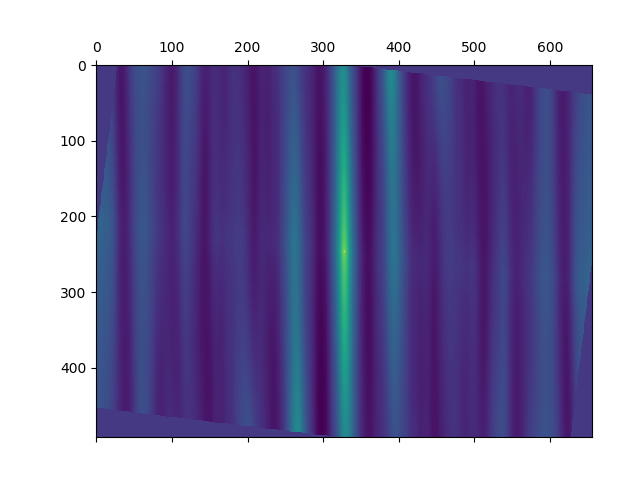

In [144]:
#rotate the image so that aligns with x and y
rotation_angle = -7 #in degrees
rotated_image_corr = ndimage.rotate(image_corr, rotation_angle, reshape=False)
plt.matshow(rotated_image_corr)

('Shape of rotated image corr: ', (492L, 656L))
('Shape of xx: ', (492L, 656L))


C:\Users\RMCGORTY\AppData\Local\Continuum\anaconda2\envs\cody\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
C:\Users\RMCGORTY\AppData\Local\Continuum\anaconda2\envs\cody\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


<IPython.core.display.Javascript object>


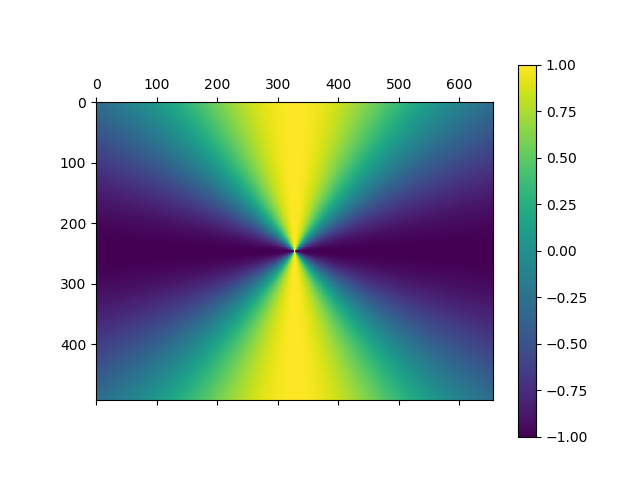

In [145]:
x = np.arange(-1*rotated_image_corr.shape[1]/2, rotated_image_corr.shape[1]/2, 1)
y = np.arange(-1*rotated_image_corr.shape[0]/2, rotated_image_corr.shape[0]/2, 1)
xx, yy = np.meshgrid(x, y)
print("Shape of rotated image corr: ", rotated_image_corr.shape)
print("Shape of xx: ", xx.shape)
cos2theta = np.cos(2*np.arctan(1.0*xx/yy))
plt.matshow(cos2theta)
plt.colorbar()

In [147]:
xc = int(rotated_image_corr.shape[0]/2)
yc = int(rotated_image_corr.shape[1]/2)
print("xc,yc: ", (xc,yc))
print("rotated_iamge_corr_minimum: ", rotated_image_corr.min())
rotated_image_corr_positive = rotated_image_corr - rotated_image_corr.min()
_, alignment_factor_numerator, _ = radiav.radav(rotated_image_corr_positive * cos2theta, xc, yc, 200)
_, alignment_factor_denominator, _ = radiav.radav(rotated_image_corr_positive, xc, yc, 200)

_, alignment_factor_numerator_np, _ = radiav.radav(rotated_image_corr * cos2theta, xc, yc, 200)
_, alignment_factor_denominator_np, _ = radiav.radav(rotated_image_corr, xc, yc, 200)

'''
Alignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. 
Journal of Rheology 62, 405–418 (2018).

'''

('xc,yc: ', (246, 328))
('rotated_iamge_corr_minimum: ', -0.19796931741692061)


'\nAlignment factor from: Varga, Z. & Swan, J. W. Large scale anisotropies in sheared colloidal gels. \nJournal of Rheology 62, 405\xe2\x80\x93418 (2018).\n\n'

<IPython.core.display.Javascript object>


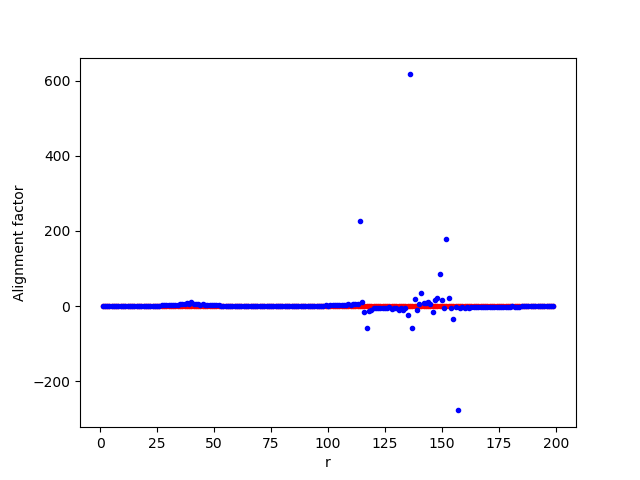

Text(0,0.5,'Alignment factor')

In [148]:
plt.figure()
plt.plot(alignment_factor_numerator / alignment_factor_denominator,'r.')
plt.plot(alignment_factor_numerator_np / alignment_factor_denominator_np,'b.')
plt.xlabel("r")
plt.ylabel("Alignment factor")

<IPython.core.display.Javascript object>


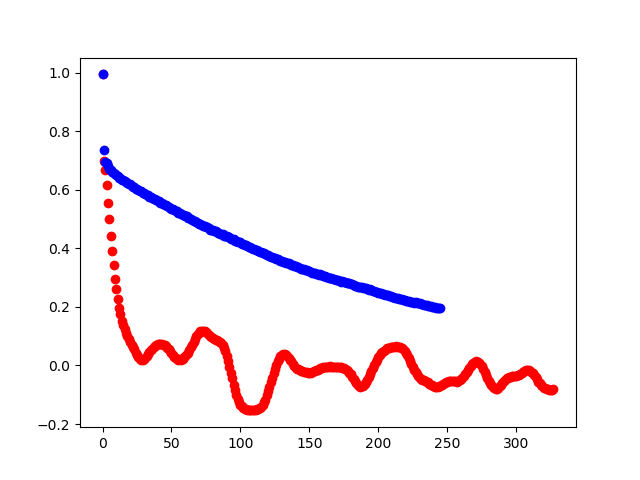

In [118]:
plt.figure()
rot_imcorr = ndimage.rotate(image_corr, rotation_angle, reshape=False)
plt.plot(rot_imcorr[image_corr.shape[0]/2, image_corr.shape[1]/2:], 'ro')
plt.plot(rot_imcorr[image_corr.shape[0]/2:, image_corr.shape[1]/2], 'bo')

<IPython.core.display.Javascript object>


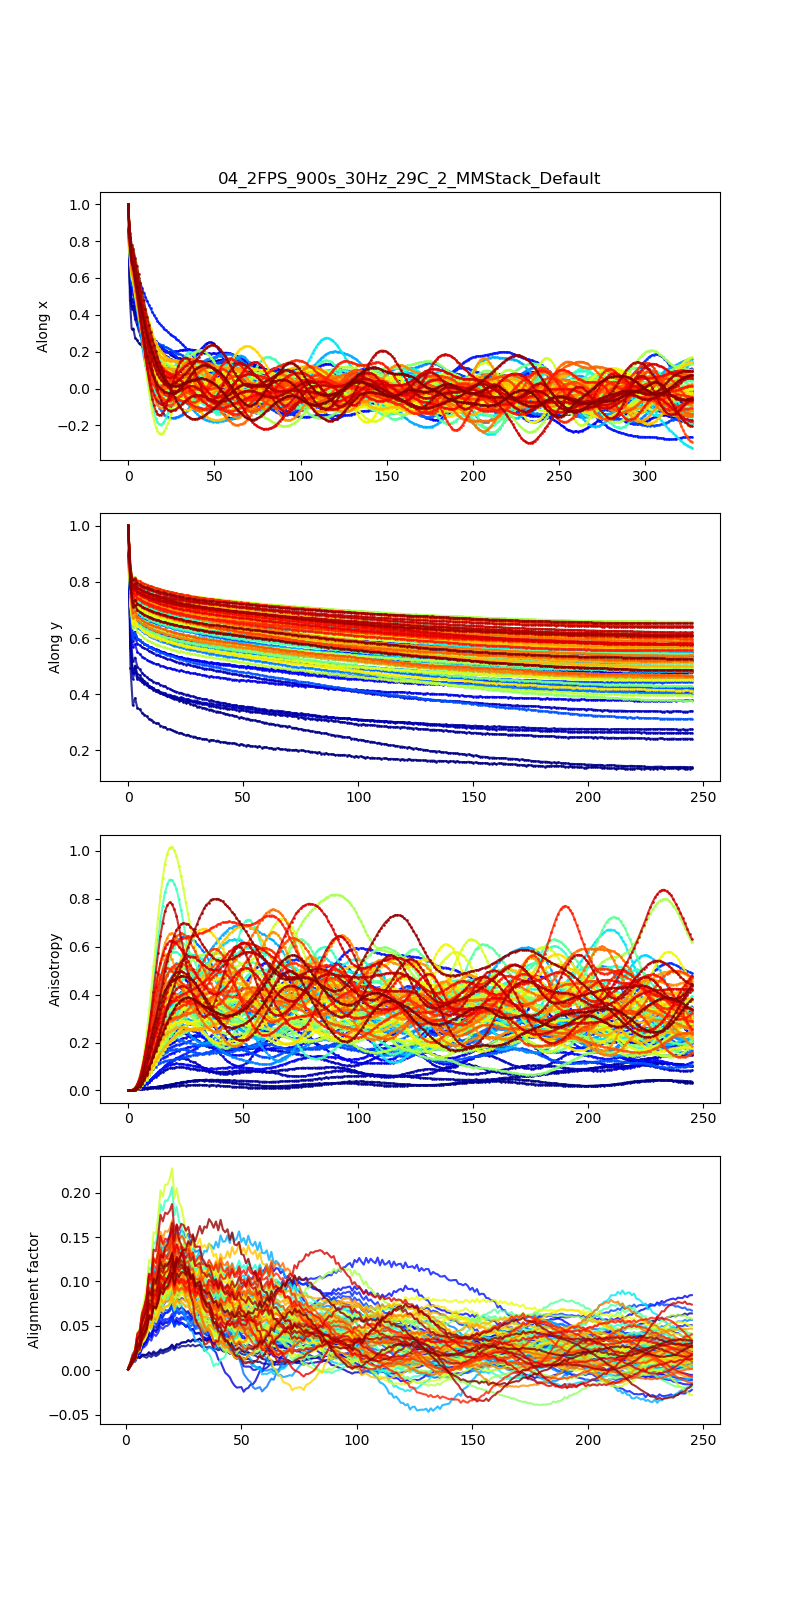

In [149]:
fig, axs = plt.subplots(4, figsize=(8,16))

#set up list of frames to analyze
list_of_frames_to_analyze = range(1, image_data.shape[0]-150, 20) #150 for 240s videos and 250 for 180s videos

color_map = plt.get_cmap('jet')
colors_for_plot = color_map(np.linspace(0,1,len(list_of_frames_to_analyze)))
marker_size = 1
alpha_value = 0.8

# take autocorrelation of previous and post frame too (and average three together)
average_neighboring_frames = True

xc = int(image_corr.shape[0]/2)
yc = int(image_corr.shape[1]/2)
smaller_of_two = min(len(image_corr[xc, yc:]), len(image_corr[xc:, yc]))

#empty dictionary to store data
correlation_data = {}
correlation_data['frames'] = list_of_frames_to_analyze
correlation_data['angle_correction'] = rotation_angle
correlation_data['average_neighboring_frames'] = average_neighboring_frames
correlation_data['autocorrelation_2d'] = np.zeros((len(list_of_frames_to_analyze),image_data[0].shape[0],image_data[0].shape[1]))
correlation_data['autocorrelation_along_horizontal'] = np.zeros((len(list_of_frames_to_analyze),int(image_data[0].shape[1]/2)))
correlation_data['autocorrelation_along_vertical'] = np.zeros((len(list_of_frames_to_analyze),int(image_data[0].shape[0]/2)))
correlation_data['anisotropy'] = np.zeros((len(list_of_frames_to_analyze),smaller_of_two))
correlation_data['alignment_factor'] = np.zeros_like(correlation_data['anisotropy'])

i=0 #counter

for frame, color in zip(list_of_frames_to_analyze,colors_for_plot):
    background_subtracted_image = image_data[frame] - median_of_images
    smoothed_image = ndimage.gaussian_filter(background_subtracted_image, gaus_filter_size)
    new_bg_corrected_image = background_subtracted_image - smoothed_image
    rotate_corrected = ndimage.rotate(new_bg_corrected_image, rotation_angle, reshape=False)
    image_corr = return_autocorrelation_of_frame(rotate_corrected)
    if average_neighboring_frames:
        smoothed_image = ndimage.gaussian_filter(image_data[frame-1] - median_of_images, gaus_filter_size)
        new_bg_corrected_image = image_data[frame-1] - median_of_images - smoothed_image
        previous_frame = ndimage.rotate(new_bg_corrected_image, rotation_angle, reshape=False)
        smoothed_image = ndimage.gaussian_filter(image_data[frame+1] - median_of_images, gaus_filter_size)
        new_bg_corrected_image = image_data[frame+1] - median_of_images - smoothed_image
        next_frame = ndimage.rotate(new_bg_corrected_image, rotation_angle, reshape=False)
        image_corr += return_autocorrelation_of_frame(previous_frame)
        image_corr += return_autocorrelation_of_frame(next_frame)
        image_corr = image_corr / 3.0
    
    xc = int(image_corr.shape[0]/2)
    yc = int(image_corr.shape[1]/2)
    axs[0].plot(image_corr[xc, yc:], '-o', c=color, alpha=alpha_value, ms=marker_size, mec=color)
    axs[0].set_ylabel("Along x")
    axs[1].plot(image_corr[xc:, yc], '-o', c=color, alpha=alpha_value, ms=marker_size, mec=color, label='Frame %i' % frame)
    axs[1].set_ylabel("Along y")
    smaller_of_two = min(len(image_corr[xc, yc:]), len(image_corr[xc:, yc]))
    anisotropy = (image_corr[xc, yc:][:smaller_of_two] - image_corr[xc:, yc][:smaller_of_two])**2
    axs[2].plot(anisotropy, '-o', c=color, alpha=alpha_value, ms=marker_size, mec=color, label='Frame %i' % frame)
    axs[2].set_ylabel("Anisotropy")
    #axs[2].legend(fontsize='xx-small')
    
    
    
    _, alignment_factor_numerator, _ = radiav.radav((image_corr+1) * cos2theta, xc, yc, smaller_of_two)
    _, alignment_factor_denominator, _ = radiav.radav(image_corr+1, xc, yc, smaller_of_two)
    
    alignment_factor = alignment_factor_numerator / alignment_factor_denominator
    axs[3].plot(alignment_factor, c=color, alpha=alpha_value, ms=marker_size, mec=color)
    
    
    #putting data in dictionary to save
    correlation_data['autocorrelation_2d'][i] = image_corr
    correlation_data['autocorrelation_along_horizontal'][i] = image_corr[xc, yc:]
    correlation_data['autocorrelation_along_vertical'][i] = image_corr[xc:, yc]
    correlation_data['anisotropy'][i] = anisotropy
    correlation_data['alignment_factor'][i] = alignment_factor
    
    i=i+1 #advance the counter by one
    
axs[0].set_title(filename.split('\\')[-1][:-8])

axs[3].set_ylabel("Alignment factor")
#axs[3].set_ylim(0,1)

f = open(filename[:-8]+"_autocorrelation_data_20frame.p","wb")
pickle.dump(correlation_data, f)
f.close()

fig.savefig(filename[:-8]+"_correlationdata_20frame.png", dpi=300)

In [51]:

axs[3].set_ylim(-0.3,0.5)


(-0.3, 0.5)

<IPython.core.display.Javascript object>


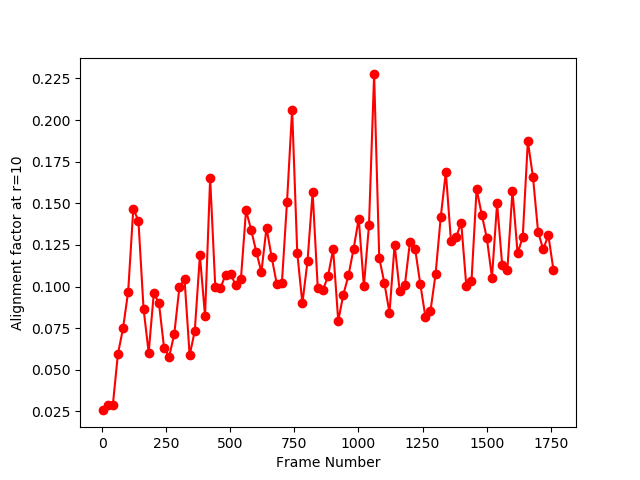

In [150]:
fig=plt.figure()
plt.plot(list_of_frames_to_analyze, correlation_data['alignment_factor'][:,20],'-ro')
plt.xlabel("Frame Number")
plt.ylabel("Alignment factor at r=10")
fig.savefig(filename[:-8]+"_r10alignmentfactor_20frame.png", dpi=300)

<IPython.core.display.Javascript object>


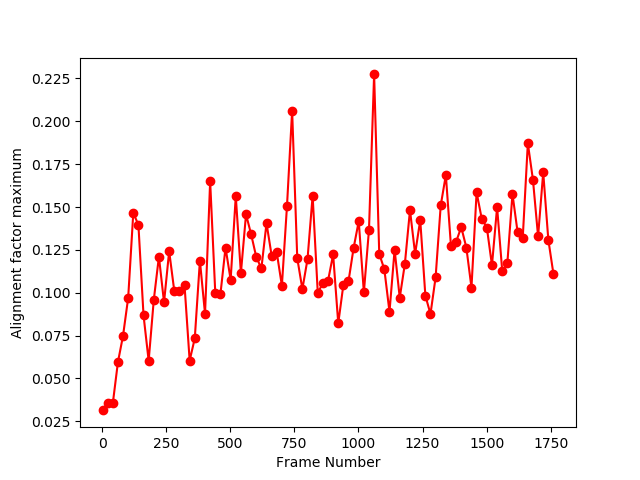

In [151]:
fig=plt.figure()
plt.plot(list_of_frames_to_analyze, correlation_data['alignment_factor'][:,1:100].max(axis=1),'-ro')
plt.xlabel("Frame Number")
plt.ylabel("Alignment factor maximum")
fig.savefig(filename[:-8]+"_maxalignmentfactor.png", dpi=300)

<IPython.core.display.Javascript object>


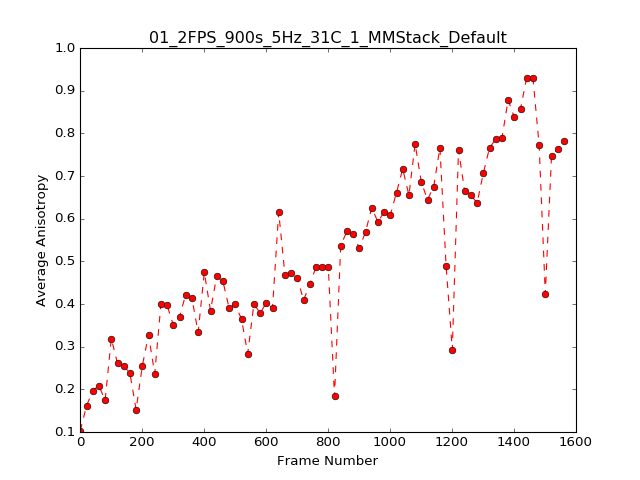

In [51]:
fig = plt.figure()
plt.plot(correlation_data['frames'], correlation_data['anisotropy'].mean(axis=1),'--ro')
plt.xlabel("Frame Number")
plt.ylabel("Average Anisotropy")
plt.title(filename.split('\\')[-1][:-8])
fig.savefig(filename[:-8]+"_correlation_anisotropy_vs_frame_20frame.png", dpi=300)

<IPython.core.display.Javascript object>


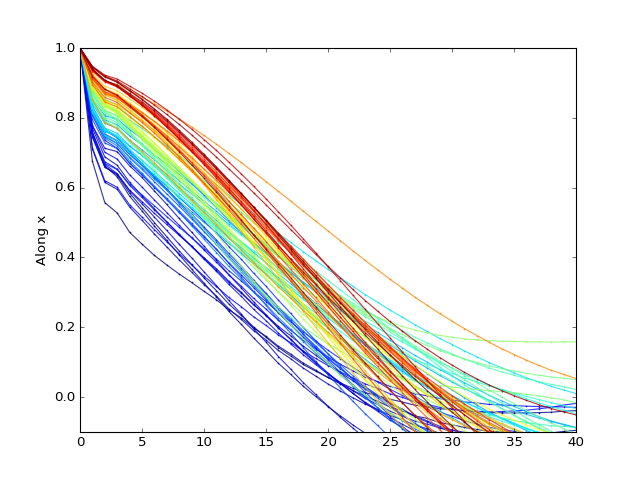

In [52]:
fig = plt.figure()
i=0
for frame, color in zip(list_of_frames_to_analyze,colors_for_plot):
    plt.plot(correlation_data['autocorrelation_along_horizontal'][i], '-o', c=color, alpha=alpha_value, ms=marker_size, mec=color)
    i=i+1
plt.ylabel("Along x")
plt.xlim(0,40)
plt.ylim(-0.1,1.0)
fig.savefig(filename[:-8]+"_horizontalcorr_zoomedin_20frame.png", dpi=300)

<IPython.core.display.Javascript object>


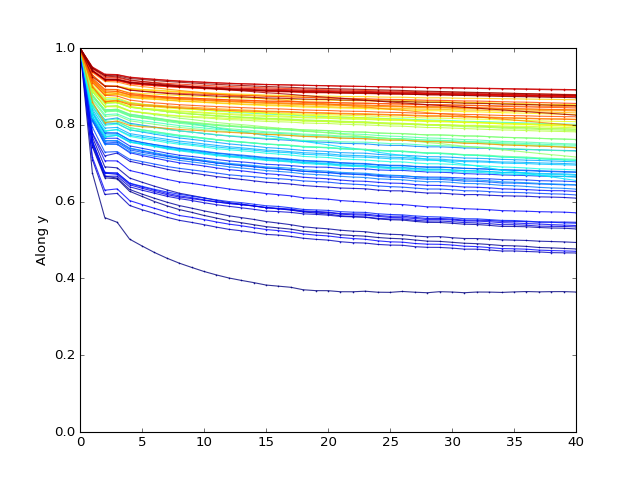

In [53]:
fig = plt.figure()
i=0
for frame, color in zip(list_of_frames_to_analyze,colors_for_plot):
    plt.plot(correlation_data['autocorrelation_along_vertical'][i], '-o', c=color, alpha=alpha_value, ms=marker_size, mec=color)
    i=i+1
plt.ylabel("Along y")
plt.xlim(0,40)
plt.ylim(0.0,1.0)
fig.savefig(filename[:-8]+"_verticalcorr_zoomedin_20frame.png", dpi=300)

correlation_data.keys()

correlation_data['anisotropy'].shape